**Assignment 3: Image Classification with Neural Networks**

*CPSC 480/580: Computer Vision*

*Yale University*

*Instructor: Alex Wong*

In this assignment, we will create a simple neural network for classifying images. We will experiment with learning rate, batch size, and different configurations of layers within the network. We will demonstrate this on the CIFAR-10 dataset.


**Prerequisites**:

1. Enable Google Colaboratory as an app on your Google Drive account

2. Create a new Google Colab notebook, this will also create a "Colab Notebooks" directory under "MyDrive" i.e.
```
/content/drive/MyDrive/Colab Notebooks
```

3. Create the following directory structure in your Google Drive
```
/content/drive/MyDrive/Colab Notebooks/CPSC 480-580: Computer Vision/Assignments
```

4. Move the 03_assignment.ipynb into
```
/content/drive/MyDrive/Colab Notebooks/CPSC 480-580: Computer Vision/Assignments
```
so that its absolute path is
```
/content/drive/MyDrive/Colab Notebooks/CPSC 480-580: Computer Vision/Assignments/03_assignment.ipynb
```

5. Prior to starting this assignment, please create a directory called 'data' within your 'Assignments' directory and within 'data' create a directory called 'assignment_03', i.e.
```
/content/drive/MyDrive/Colab Notebooks/CPSC 480-580: Computer Vision/Assignments/data/assignment_03
```

6. Set up GPU runtime by selecting `Runtime` on the top tool bar, then selecting `Change runtime type` in the drop-down menu, selecting `GPU` under Hardware accelerator and clicking `Save`.


**Submission**:

1. Implement all TODOs in the code blocks below.

2. Run the Colab Notebook to produce results for each code block.

3. Report accuracy of neural network and ResNet18. Your accuracy should exceed 50% for neural network and 70% for ResNet18.

```
Neural network:
Mean accuracy over 10000 images: 52.490%

ResNet18:
Mean accuracy over 10000 images: 84.630%
```

4. Answer the following questions:

```
4a. We have seen how performance of deep neural networks correlate well with their size, e.g., from AlexNet to VGGNet. Suppose that we increased the number of layers in VGGNet by 100x, with sufficient compute resources, will we have observe performance to continue to increase? Explain why or why not?

Answer: No, as shown by the degradation problem from the ResNet paper, training becomes unstable as depth increases in a VGG architecture. This is because gradients vanish which prevents early layers from learning, so the bottleneck is not actually compute. Without skip connections to preserve gradient flow, the performance would most likely decrease based on the paper.
```
```
4b. We have seen figures of convolutional neural networks (CNNs) to resemble a Gaussian Pyramid . Explain each component (convolutional layer, pooling, etc.) of CNNs and how it correspond to Gaussian Pyramid, and how CNNs differ from them.

Answer:
Two components of CNNs include the convolutional layer and pooling. In CNNs, the convolution kernel is learned and changes across levels, whereas for Gaussian Pyramids, the kernel is always gaussian and fixed. Both the pyramid and CNNs (after pooling) decrease the resolution of the input tensor as depth increases, but for differnet reasons. Resolution decrease in CNNs is because of pooling (statistical downsampling of max/avg. over local patches) or strided convolutions, whereas in pyramids it occurs due to removing every other pixel.
```

```
4c. Suppose that we have a Bag of (Visual) Words classifier with a perceptron and a CNN classifier. Explain how each component in the Bag of Words classifier relate to the CNN classifier in inference

Answer: SIFT descriptors in BoVW are conceptually similar to feature maps in a CNN. Assigning descriptors to visual words (single global histogram) is similar to how a CNN aggregates its local features to a compressed form using downsampling or pooling. Lastly, the perceptron classifier used in BoVW is conceptually similar to the fully connected layer at output during inference.
```

```
4d. List the different types of regularizations one can impose on CNNs, and provide an example of each.

Answer: Regularizations are essentially any techniques used to reduce the network from memorizing the training data rather than learning patterns (overfitting). Different types of regularization:
* Weight (e.g. L2, L1 that penalize large weights)
* Architectural (e.g. dropout, batch normalization -- changes the network with noise or constraints so it can't just memorize training data)
* Data-based (e.g. random flipping, jittering, adding noise)
* Training-time (e.g. stochastic gradient descent noise, learning rate schedules -- goal is to prevent overly confident predictions)
```

5. List any collaborators.

```
Collaborators: Doe, Jane (Please write names in <Last Name, First Name> format)

Collaboration details: Discussed ... implementation details with Jane Doe.
```



Import packages

In [40]:
from google.colab import drive
from google.colab import auth
from google.auth import default
import os

drive.mount('/content/drive/', force_remount=True)
os.chdir('/content/drive/MyDrive/Colab Notebooks/CPSC 480-580: Computer Vision/Assignments')

Mounted at /content/drive/


In [41]:
import numpy as np
import matplotlib.pyplot as plt

import torch, torchvision
import torch.nn as nn

Utility functions for plotting

In [42]:
def config_plot():
    '''
    Function to remove axis tickers and box around figure
    '''

    plt.box(False)
    plt.axis('off')

In [43]:
def plot_images(images, n_row, n_col, subplot_titles, dpi=200, cmap=None):
    '''
    Plot images in a grid

    Arg(s):
        images : list[list[numpy]]
            lists of lists of images
        n_row : int
            number of rows in plot
        n_col : int
            number of columns in plot
        subplot_titles : list[list[str]]
            lists of lists of titles corresponding to each subplot
        dpi : int
            dots per inch for figure
        cmap : matplotlib.Colormap
            dots per inch for figure
    '''

    # Instantiate a figure
    fig = plt.figure(dpi=dpi)

    # Iterate through each row of images
    for row_idx in range(n_row):

        # Iterate through each column of row
        for col_idx in range(n_col):

            # Compute subplot index based on row and column indices
            subplot_idx = row_idx * n_col + col_idx + 1

            # Create axis object for current subplot
            ax = fig.add_subplot(n_row, n_col, subplot_idx)

            # Plot the image with provided color
            ax.set_title(subplot_titles[row_idx][col_idx], fontsize=5)
            ax.imshow(images[row_idx][col_idx], cmap=cmap)

            config_plot()

    fig.subplots_adjust(wspace=0, hspace=0.5)
    plt.show()

Hyper-parameters for training neural network

In [44]:
# TODO: Choose hyper-parameters for neural network or ResNet18
# Note: Accuracy of Neural Network should exceed 52%, ResNet18 should exceed 70%

# Architecture - neural_network or resnet18
ARCHITECTURE = 'resnet18'

# Batch size - number of images within a training batch of one training iteration i.e. 64
N_BATCH = 64

# Training epoch - number of passes through the full training dataset i.e. 20
N_EPOCH = 20

'''
conceptual note: goal is to get the lowest loss --> good predictions for classification
- loss function measures how wrong you are
Feedback:
- if loss flattens → learning stalled
- if it spikes → learning rate too high
- if it decreases slowly → learning rate too low
'''
# Learning rate - step size to update parameters i.e. 1e-1
# why?: learning rate is the step size taken toward min(loss_curve) --> don't want to overshoot
LEARNING_RATE = 1e-1

# Learning rate decay - scaling factor to decrease learning rate at the end of each decay period i.e. 0.10
# why?: as training progresses, we need steps to get smaller to fine-tune around the min
LEARNING_RATE_DECAY = 0.95

# Learning rate decay period - number of epochs before reducing/decaying learning rate i.e. 5
LEARNING_RATE_DECAY_PERIOD = 5

Define Neural Network

In [45]:
class NeuralNetwork(torch.nn.Module):
    '''
    Neural network class of fully connected layers

    Arg(s):
        n_input_feature : int
            number of input features
        n_output : int
            number of output classes
    '''

    def __init__(self, n_input_feature, n_output):
        super(NeuralNetwork, self).__init__()

        # Create your 6-layer neural network using fully connected layers with ReLU activations
        # conceptual note: m in docstrings is obj. representing a layer
        # https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
        # https://pytorch.org/docs/stable/generated/torch.nn.functional.relu.html
        # https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html

        # TODO: Instantiate 5 fully connected layers
        self.relu = nn.ReLU() # applied in forward()
        self.fully_connected_layer_1 = nn.Linear(n_input_feature, 1024) # note: d = n_input_feature --> matrix mult.
        self.fully_connected_layer_2 = nn.Linear(1024, 512)
        self.fully_connected_layer_3 = nn.Linear(512, 256)
        self.fully_connected_layer_4 = nn.Linear(256, 256)
        self.fully_connected_layer_5 = nn.Linear(256, 128)

        # TODO: Define output layer
        self.output = nn.Linear(128, n_output)
    def forward(self, x):
        '''
        Forward pass through the neural network

        Arg(s):
            x : torch.Tensor[float32]
                tensor of N x d
        Returns:
            torch.Tensor[float32]
                tensor of n_output predicted class
        '''

        # TODO: Implement forward function
        # high level: input → [Linear → ReLU] × 5 → Linear (to n_output)
        x = self.fully_connected_layer_1(x)
        x = self.relu(x) # recall: relu for non-linearity to model complexity
        x = self.fully_connected_layer_2(x)
        x = self.relu(x)
        x = self.fully_connected_layer_3(x)
        x = self.relu(x)
        x = self.fully_connected_layer_4(x)
        x = self.relu(x)
        x = self.fully_connected_layer_5(x)
        x = self.relu(x)

        output_logits = self.output(x)

        return output_logits


In [46]:
'''
OH conceptual architecture outline:
1. save the input tensor as the skip-path identity.
2. main path:
    - Apply conv1 (may change channels or spatial size depending on stride).
    - Apply ReLU.
    - Apply conv2.
3. skip path:
    - If the shape of identity does NOT match the shape of the main path output,
      project identity through a 1×1 convolution with the same stride
      to enforce matching dimensions.
4. add the main path output and the (possibly projected) skip-path tensor.

5. apply a final ReLU.

6. return the resulting tensor.
'''
class ResNetBlock(torch.nn.Module):
    '''
    Basic ResNet block class

    Arg(s):
        in_channels : int
            number of input channels
        out_channels : int
            number of output channels
        stride : int
            stride of convolution
    '''
    def __init__(self,
                 in_feature, # C_in
                 out_channels, # C_out
                 stride=1):
        super(ResNetBlock, self).__init__()

        # TODO: Implement ResNet block based on
        # Deep Residual Learning for Image Recognition: https://arxiv.org/pdf/1512.03385.pdf

        # Note: a residual block contains multiple NN layers (a mini network)
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=in_feature, out_channels=out_channels,
                      kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

        self.conv2 = nn.Sequential( # don't apply ReLU to preserve identity function
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
        )

        # project if dimensions don't match
        self.projection = None
        if stride != 1 or in_feature != out_channels:
          self.projection = nn.Sequential(
            nn.Conv2d(in_channels=in_feature, out_channels=out_channels,
                      kernel_size=1, stride=stride),
            nn.BatchNorm2d(out_channels)
          )
        self.relu = nn.ReLU()
        self.out_channels = out_channels

    def forward(self, x):
        '''
        Forward input x through a basic ResNet block

        Arg(s):
            x : torch.Tensor[float32]
                N x C x H x W input tensor
        Returns:
            torch.Tensor[float32] : N x K x h x w output tensor
        '''

        # TODO: Implement forward function
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)

        # convolve to match shape of output
        if self.projection is not None:
          residual = self.projection(x)
        out += residual
        out = self.relu(out)
        return out


class ResNet18(torch.nn.Module):
    '''
    ResNet18 convolutional neural network

    Arg(s):
        n_input_channel : int
            number of channels in input data
        n_output : int
            number of output classes
    '''

    def __init__(self, n_input_feature, n_output):
        super(ResNet18, self).__init__()

        # TODO: Implement ResNet
        # Based on https://arxiv.org/pdf/1512.03385.pdf

        # initial root conv
        self.in_channels = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=n_input_feature, out_channels=self.in_channels,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(self.in_channels),
            nn.ReLU(inplace=True)
        )

        # wire together blocks for each layer
        self.layer1 = self._make_layer(ResNetBlock, 64, 2, stride=1)
        self.layer2 = self._make_layer(ResNetBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(ResNetBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(ResNetBlock, 512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, n_output)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
          layers.append(block(self.in_channels, out_channels, stride))
          self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        '''
        Forward input x through a ResNet encoder

        Arg(s):
            x : torch.Tensor[float32]
                N x C x H x W input tensor
        Returns:
            torch.Tensor[float32] : N x K x h x w output tensor
        '''

        # TODO: Implement forward function
        out = self.conv1(x)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avgpool(out) # collapse H x W to 1 x 1 -> (N, 512, 1, 1)
        out = out.view(out.size(0), -1) # flatten -> (N, 512 * 1 * 1)
        out = self.fc(out)

        return out

Define training loop

In [47]:
def train(net,
          dataloader,
          n_epoch,
          optimizer,
          learning_rate_decay,
          learning_rate_decay_period,
          device):
    '''
    Trains the network using a learning rate scheduler

    Arg(s):
        net : torch.nn.Module
            neural network or ResNet
        dataloader : torch.utils.data.DataLoader
            # https://pytorch.org/docs/stable/data.html
            dataloader for training data
        n_epoch : int
            number of epochs to train
        optimizer : torch.optim
            https://pytorch.org/docs/stable/optim.html
            optimizer to use for updating weights
        learning_rate_decay : float
            rate of learning rate decay
        learning_rate_decay_period : int
            period to reduce learning rate based on decay e.g. every 2 epoch
        device : str
            device to run on
    Returns:
        torch.nn.Module : trained network
    '''

    device = 'cuda' if device == 'gpu' or device == 'cuda' else 'cpu'
    device = torch.device(device)

    # TODO: Move model to device
    net = net.to(device)

    # TODO: Define cross entropy loss
    # https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
    loss_func = nn.CrossEntropyLoss()

    for epoch in range(n_epoch):
        '''
        conceptual note:
        - importance of loss --> if it decr., shows that the network weights
          are learning to predict labels more accurately
        - loss = direct measurement of learning
        - loss is for teaching & accuracy for evaluation
        - small loss means model is closer to correct and the goal
        '''
        # Accumulate total loss for each epoch
        net.train()
        total_loss = 0.0

        # TODO: Decrease learning rate when learning rate decay period is met
        # e.g. decrease learning rate by a factor of decay rate every 2 epoch
        # by modifying optimizer.param_groups
        if epoch and epoch % learning_rate_decay_period == 0:
            for param_group in optimizer.param_groups:
              param_group['lr'] *= learning_rate_decay

        for batch, (images, labels) in enumerate(dataloader):

            # TODO: Move images and labels to device
            images = images.to(device)
            labels = labels.to(device)

            # TODO: Vectorize images
            if ARCHITECTURE == 'neural_network':
              images = images.view(images.size(0), -1)

            # TODO: Clear gradients so we don't accumlate them from previous batches
            optimizer.zero_grad()

            # TODO: Forward through the network
            outputs = net(images)

            # TODO: Compute loss function and parameters by backpropagation
            loss = loss_func(outputs, labels)
            loss.backward() # computes gradients w.r.t all parameters
            optimizer.step() # update weights

            # TODO: Accumulate total loss for the epoch
            total_loss += loss.item() * images.size(0)

        # avg. training loss over the whole training dataset
        mean_loss = total_loss / len(dataloader.dataset)

        # Log average loss over the epoch
        print('Epoch={}/{}  Loss: {:.3f}'.format(epoch + 1, n_epoch, mean_loss))

    return net


Define evaluation loop

In [48]:
import matplotlib.pyplot as plt
def evaluate(net, dataloader, class_names, device):
    '''
    Evaluates the network on a dataset

    Arg(s):
        net : torch.nn.Module
            neural network
        dataloader : torch.utils.data.DataLoader
            # https://pytorch.org/docs/stable/data.html
            dataloader for training data
        class_names : list[str]
            list of class names to be used in plot
        device : str
            device to run on
    '''

    device = 'cuda' if device == 'gpu' or device == 'cuda' else 'cpu'
    device = torch.device(device)

    # TODO: Move model to device
    net = net.to(device)
    net.eval()

    n_correct = 0
    n_sample = 0

    # Make sure we do not backpropagate
    with torch.no_grad():

        for (images, labels) in dataloader:
            # Store the original images for visualization before any flattening
            original_images_for_viz = images.clone()

            # TODO: Move images and labels to device
            images = images.to(device)
            labels = labels.to(device)

            # TODO: Vectorize images
            if ARCHITECTURE == 'neural_network':
               images = images.view(images.size(0), -1)
               outputs = net(images)
            else:
              outputs = net(images)

            # Accumulate number of samples
            n_sample = n_sample + labels.shape[0]

            # TODO: Check if our prediction is correct
            _, predicted = outputs.max(1)
            n_correct += predicted.eq(labels).sum().item()

            # for visualization
            last_images = original_images_for_viz.to(device) # Use the stored original images
            last_labels = labels
            last_predicted = predicted

    # TODO: Compute mean accuracy
    mean_accuracy = 100. * n_correct / n_sample

    print('Mean accuracy over {} images: {:.3f}%'.format(n_sample, mean_accuracy))

    # TODO: Convert the last batch of images back to original shape
    images = last_images

    # TODO: Move images back to cpu and to numpy array
    images = images.detach().cpu().numpy()

    # TODO: torch.Tensor operate in (N x C x H x W), convert it to (N x H x W x C)
    images = np.transpose(images, (0, 2, 3, 1))

    # TODO: Move the last batch of labels to cpu and convert them to numpy and
    # map them to their corresponding class labels
    labels = last_labels.detach().cpu().numpy()
    label_names = [class_names[idx] for idx in labels]

    # TODO: Move the last batch of outputs to cpu, convert them to numpy and
    # map them to their corresponding class labels
    preds = last_predicted.detach().cpu().numpy()
    pred_names = [class_names[idx] for idx in preds]

    # Convert images, outputs and labels to a lists of lists
    grid_size = 5

    images_display = []
    subplot_titles = []

    for row_idx in range(grid_size):
        # TODO: Get start and end indices of a row
        idx_start = row_idx * grid_size
        idx_end = (row_idx + 1) * grid_size

        # TODO: Append images from start to end to image display array
        images_display.append(images[idx_start:idx_end])

        # TODO: Append text of 'output={}\nlabel={}' substituted with output and label to subplot titles
        titles = [
            f"output={pred_names[i]}\nlabel={label_names[i]}"
            for i in range(idx_start, idx_end)
        ]
        subplot_titles.append(titles)

    # TODO: Plot images with class names and corresponding groundtruth label in a 5 by 5 grid
    ROW_SIZE, COL_SIZE = 5, 5
    fig, axes = plt.subplots(ROW_SIZE, COL_SIZE, figsize=(10, 10))

    for r in range(ROW_SIZE):
        for c in range(COL_SIZE):
            # Clamp image values to [0, 1] for proper display
            display_image = images_display[r][c]
            display_image = np.clip(display_image, 0, 1)
            axes[r, c].imshow(display_image)
            axes[r, c].set_title(subplot_titles[r][c])
            axes[r, c].axis('off')

Training a neural network for image classification

In [49]:
'''
Set up dataloading
'''
# Create transformations to apply to data during training
# https://pytorch.org/docs/stable/torchvision/transforms.html
transforms_train = torchvision.transforms.Compose([
    # TODO: Include random brightness, contrast, saturation between [0.8, 1.2] and
    # horizontal flip augmentations
    torchvision.transforms.ColorJitter([0.8, 1.2], [0.8, 1.2], [0.8, 1.2]),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor()
])

# Download and setup CIFAR10 training set using preconfigured torchvision.datasets.CIFAR10
cifar10_train = torchvision.datasets.CIFAR10(
    root=os.path.join('data', 'assignment_03'),
    train=True,
    download=True,
    transform=transforms_train)

# TODO: Setup a dataloader (iterator) to fetch from the training set using
# torch.utils.data.DataLoader and set shuffle=True, drop_last=True, num_workers=2
dataloader_train = torch.utils.data.DataLoader(
    cifar10_train,
    batch_size=N_BATCH,
    shuffle=True,
    drop_last=True,
    num_workers=2
)

# Define the possible classes in CIFAR10
class_names = [
    'plane',
    'car',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]

# CIFAR10 has 10 classes
n_class = len(class_names)

'''
Set up model and optimizer
'''
# TODO: Compute number of input features depending on ARCHITECTURE
images, labels = next(iter(dataloader_train))
C, H, W = images.shape[1], images.shape[2], images.shape[3]
if ARCHITECTURE == 'neural_network':
  n_input_feature = C * H * W
elif ARCHITECTURE == 'resnet18':
    n_input_feature = C

# TODO: Instantiate neural network or ResNet18 depending on ARCHITECTURE
if ARCHITECTURE == 'neural_network':
    net = NeuralNetwork(n_input_feature, n_class)
elif ARCHITECTURE == 'resnet18':
    net = ResNet18(n_input_feature, n_class)

# TODO: Setup learning rate SGD optimizer
# https://pytorch.org/docs/stable/optim.html?#torch.optim.SGD
optimizer = torch.optim.SGD(net.parameters(), lr=LEARNING_RATE)

'''
Train network and store weights
'''
# TODO: Train network with device='cuda'
net = train(net=net,
            dataloader=dataloader_train,
            n_epoch=N_EPOCH,
            optimizer=optimizer,
            learning_rate_decay=LEARNING_RATE_DECAY,
            learning_rate_decay_period=LEARNING_RATE_DECAY_PERIOD,
            device='cuda')

# TODO: Save weights into checkpoint
torch.save({
    'model_state_dict': net.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}, 'checkpoint.pth')

Epoch=1/20  Loss: 1.598
Epoch=2/20  Loss: 1.017
Epoch=3/20  Loss: 0.762
Epoch=4/20  Loss: 0.606
Epoch=5/20  Loss: 0.509
Epoch=6/20  Loss: 0.424
Epoch=7/20  Loss: 0.363
Epoch=8/20  Loss: 0.311
Epoch=9/20  Loss: 0.262
Epoch=10/20  Loss: 0.225
Epoch=11/20  Loss: 0.181
Epoch=12/20  Loss: 0.153
Epoch=13/20  Loss: 0.129
Epoch=14/20  Loss: 0.106
Epoch=15/20  Loss: 0.096
Epoch=16/20  Loss: 0.073
Epoch=17/20  Loss: 0.062
Epoch=18/20  Loss: 0.057
Epoch=19/20  Loss: 0.049
Epoch=20/20  Loss: 0.039


Mean accuracy over 10000 images: 84.630%


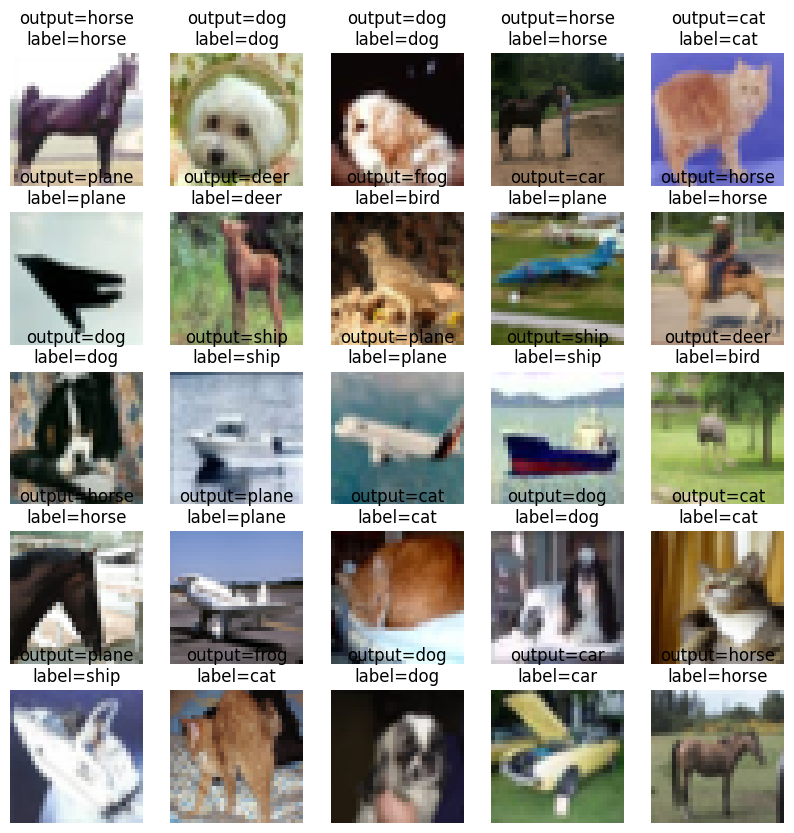

In [50]:
'''
Set up dataloading
'''
# TODO: Create transformations to apply to data during testing
# https://pytorch.org/docs/stable/torchvision/transforms.html
transforms_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

# TODO: Download and setup CIFAR10 testing set using
# preconfigured torchvision.datasets.CIFAR10
cifar10_test = torchvision.datasets.CIFAR10(
    root=os.path.join('data', 'assignment_03'),
    train=False,
    transform=transforms_test)

# TODO: Setup a dataloader (iterator) to fetch from the testing set using
# torch.utils.data.DataLoader and set shuffle=False, drop_last=False, num_workers=2
# Set batch_size to 25
dataloader_test = torch.utils.data.DataLoader(cifar10_test, batch_size=25, shuffle=False, drop_last=False, num_workers=2)

'''
Set up model
'''
# TODO: Compute number of input features depending on ARCHITECTURE
if ARCHITECTURE == 'neural_network':
  n_input_feature = C * H * W
elif ARCHITECTURE == 'resnet18':
    n_input_feature = C

# TODO: Instantiate neural network or ResNet18 depending on ARCHITECTURE
if ARCHITECTURE == 'neural_network':
    net = NeuralNetwork(n_input_feature, n_class)
elif ARCHITECTURE == 'resnet18':
    net = ResNet18(n_input_feature, n_class)

'''
Restore weights and evaluate network
'''
# TODO: Load network from checkpoint
device = 'cuda' if torch.cuda.is_available() else 'cpu'
checkpoint = torch.load('checkpoint.pth', map_location=device)
net.load_state_dict(checkpoint['model_state_dict'])

# TODO: Set network to evaluation mode
net.eval()

# TODO: Evaluate network on testing set with device='cuda'
evaluate(net, dataloader_test, class_names, device='cuda')